Previously, we established a baseline model with 64.24% accuracy for CIFAR-10 dataset. In this post, we will exploit a specific technique called _image augmentation_ to see if it can improve the performance of our model.

## I - Load packages

In [1]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(1)

In [2]:
# Define constants
NUMBER_OF_CLASSES = 10
EPOCHS = 80
BATCH_SIZE = 2**4
VALIDATION_SPLIT = .2

## II - Load datasets and Process

In [3]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [4]:
# Check dataset data type
print("X_train's data type:", X_train.dtype)
print("X_test's data type:", X_test.dtype)

X_train's data type: uint8
X_test's data type: uint8


In [5]:
# Convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print("X_train's data type:", X_train.dtype)
print("X_test's data type:", X_test.dtype)

X_train's data type: float32
X_test's data type: float32


In [6]:
# Normalize pixels values in the dataset to the (0-1) scale
X_train = np.divide(X_train, 255)
X_test = np.divide(X_test, 255)

# Check peak-to-peak values
print("X_train peak-to-peak dataset:", np.ptp(X_train))
print("X_train peak-to-peak dataset:", np.ptp(X_test))

X_train peak-to-peak dataset: 1.0
X_train peak-to-peak dataset: 1.0


In [7]:
# One-hot encode the target variables
Y_train = keras.utils.to_categorical(Y_train, NUMBER_OF_CLASSES)
Y_test = keras.utils.to_categorical(Y_test, NUMBER_OF_CLASSES)

# Check
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Y_train shape: (50000, 10)
Y_test shape: (10000, 10)


### III - Image Augmentation

Image augmentation is a technique that we can use to _artificially_ expand our training set by rotating, shifting, flipping or zooming our training datasets to generate new images.

There are several ways to augment our image data with `keras`: either using `Sequential()` class or `ImageDataGenerator` class.

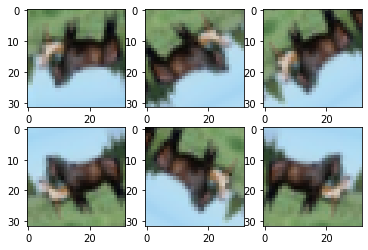

In [8]:
# Method 1: using Sequential()
image_augmentation = keras.Sequential([
    # randomly flip vertically and horizontally images
    keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    
    # randomly rotate images by .2*360
    keras.layers.experimental.preprocessing.RandomRotation(0.1)
])
idx = 12 # plot image #12
img = tf.expand_dims(X_train[idx], axis=0)
for i in range(6):
    augmented_image = image_augmentation(img)
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(augmented_image[0])

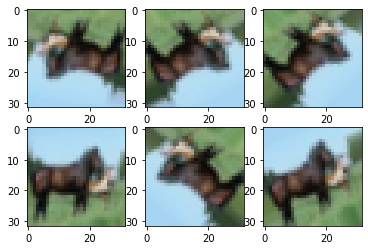

In [9]:
# Method 2: using ImageatDataGenerator() class
data_gen = ImageDataGenerator(rotation_range=0.2*360,
                              horizontal_flip=True,
                              vertical_flip=True)
idx = 12 # plot image #12
img = tf.expand_dims(X_train[12], axis=0)
aug_iterator = data_gen.flow(img, batch_size=1)
for i in range(6):
    batch = aug_iterator.next()
    img = batch[0].astype('float32')
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(img)

## IV - Build the Model

In [10]:
# Using ImageDataGenerator() to generate image on the fly while training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset="training")
validation_generator = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset="validation")

In [11]:
# Confirm the lengths of training and validation iterators
print("Batches train=%i, test=%i" % (len(train_generator), len(validation_generator)))

Batches train=2500, test=625


In [12]:
# Build a LeNet-5 model with keras's Sequential()
cifar10_model = keras.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(units=120, activation="relu"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=84, activation="relu"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=10, activation="softmax")
])

In [13]:
# Model summary
cifar10_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 6)         24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 16)       

In [14]:
cifar10_model.compile(optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

In [ ]:
history = cifar10_model.fit(train_generator,
                  validation_data=validation_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=EPOCHS,
                  verbose=1)

In [16]:
# Evaluate on the test set
cifar10_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.9020 - accuracy: 0.6900


[0.9019834995269775, 0.6899999976158142]

## III - Model History

In [17]:
# Extract history df
df_loss_acc = pd.DataFrame(history.history)
df_loss_acc.describe()

,loss,accuracy,val_loss,val_accuracy
count,80.000000,80.000000,80.000000,80.000000
mean,1.014221,0.642896,1.067335,0.627777
std,0.139717,0.051410,0.187994,0.057312
min,0.895227,0.373825,0.896794,0.318900
25%,0.929771,0.631181,0.958392,0.611000
50%,0.967341,0.660850,1.022163,0.640700
75%,1.046793,0.673894,1.108047,0.662375
max,1.738089,0.685925,2.245636,0.687100


In [18]:
# Make two corresponding data frames from history df
df_loss = df_loss_acc[["loss", "val_loss"]]
df_loss = df_loss.rename(columns={"loss":"Training Loss", "val_loss": "Dev Loss"})

df_acc = df_loss_acc[["accuracy", "val_accuracy"]]
df_acc = df_acc.rename(columns={"accuracy":"Training Accuracy", "val_accuracy": "Dev Accuracy"})

<AxesSubplot:title={'center':'Training vs Dev Accuracy'}>

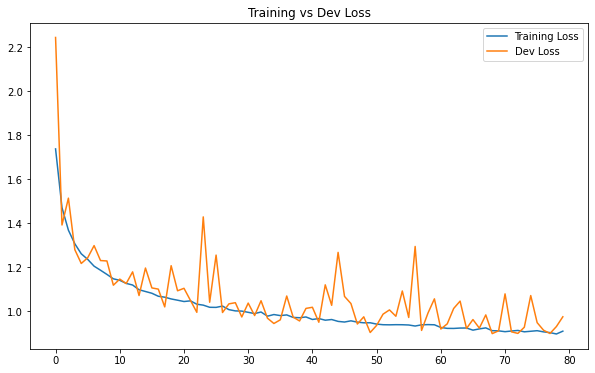

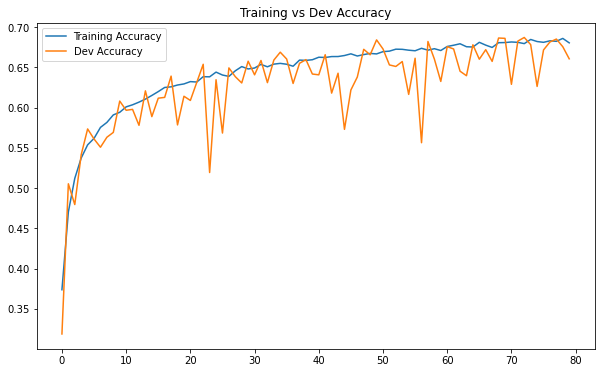

In [19]:
# Plot loss and accuracy dataframes
df_loss.plot(title="Training vs Dev Loss", figsize=(10, 6))
df_acc.plot(title="Training vs Dev Accuracy", figsize=(10, 6))

With image augmentation, we now can see that our training and validation metrics more or less correlate with each other, even after 80 epochs. There is no overfitting issue with model, which is a good thing because in the previous post, our baseline model was terribly overfitted. 

This is due to image augmentation. This technique was definitely helpful in conquering overfitting this time. By feeding the model with artificially generated images, image augmentation works as a regularizer when the model have to "see" more distorted pictures in the training set, which is helpful to improve generalization. Another way to think about image augmentation is that it essentially expand the size of our training set, and thus, can improve the performance of model. 

Nevertheless, the results of the model show that it is highly biased: there is still room for improvement. In the next post, we will see how we can improve it further.